In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 河北資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-河北1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-河北2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-河北3.xls')
patent_df = pd.concat([df1,df2,df3],ignore_index=True)

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)


firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'13\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [29]:
patent_df_firm

,序号,标题,文献页数,合享价值度,链接到incoPat,公开（公告）号,公开（公告）日,申请号,申请日,申请人,标准化申请人,申请人国别代码,申请人省市代码,中国申请人地市,中国申请人区县,申请人地址,申请人类型,优先权信息,权利要求数量,专利类型,发明人,IPC,CPC,简单同族,扩展同族,inpadoc同族,同族国家,简单同族个数,扩展同族个数,inpadoc同族个数,引证专利,被引证专利,被引证次数,引证科技文献,专利寿命（月）,被引证国别(forward),失效日,公开国别
74863,22295,便捷拆装装置,5,8,到incoPat中查看\r\nCN201168724Y,CN201168724Y,2008-12-24,CN200820078421.6,2008-01-04,邢台海裕百特极片成套设备有限公司,NaN,中国,河北; 13,[邢台],[桥西],河北省邢台市郭守敬北路386号,企业,CN200820078421 20080104,2,实用新型,弭丽峰; 张继风,B21B31/08,NaN,CN201168724Y,CN201168724Y,CN201168724Y,CN,1,1,1,NaN,WO2013123740A1; CN105776022A,2,NaN,120.0,"世界知识产权组织, 中国",2018-01-04,CN
75646,23078,风道一体化顶篷,5,4,到incoPat中查看\r\nCN201136427Y,CN201136427Y,2008-10-22,CN200820076021.1,2008-01-05,河北省冀州市汽车装饰件厂,NaN,中国,河北; 13,[衡水],[冀州],河北省冀州市北内漳村,企业,CN200820076021 20080105,4,实用新型,巩志刚; 巩君瑞,B60H1/24,NaN,CN201136427Y,CN201136427Y,CN201136427Y,CN,1,1,1,NaN,NaN,0,NaN,72.0,NaN,2014-01-05,CN
57610,5042,布袋除尘器用气密性回转反吹风装置,9,6,到incoPat中查看\r\nCN101279172B,CN101279172B,2011-07-27,CN200810055849.3,2008-01-10,秦皇岛市清青环保设备有限公司,NaN,中国,河北; 13,[秦皇岛],[海港],河北省秦皇岛市海阳路558号,企业,NaN,6,发明授权,郦剑飞,B01D46/04,NaN,CN101279172B; CN101279172A,CN101279172B; CN101279172A,CN101279172A; CN101279172B,CN,2,2,2,EP1618943A1; CN2338078Y; CN2447645Y; CN2122677Y; JP04090817A,NaN,0,NaN,48.0,NaN,2012-01-10,CN
74881,22313,带顶盖和底托的奶粉听,5,6,到incoPat中查看\r\nCN201169408Y,CN201169408Y,2008-12-24,CN200820076098.9,2008-01-17,石家庄市正通药品包装有限公司,NaN,中国,河北; 13,[石家庄],[新华],河北省石家庄市警安路88号,企业,CN200820076098 20080117,4,实用新型,白志刚; 王东辉; 朱景春; 郝占山; 左建忠,B65D21/032; B65D51/24,NaN,CN201169408Y,CN201169408Y,CN201169408Y,CN,1,1,1,NaN,CN103287708B; CN103287709B; CN105000248A; CN103287708A; CN103287729A; CN105667996A; CN103287709A; CN106414259A; CN103287717A,9,NaN,36.0,中国,2011-01-17,CN
75326,22758,组合式客车翻板,5,6,到incoPat中查看\r\nCN201151394Y,CN201151394Y,2008-11-19,CN200820001171.6,2008-01-18,唐山龙铁商贸有限公司,NaN,中国,河北; 13,[唐山],[丰润],河北省唐山市丰润区3小区48－3－203,企业,CN200820001171 20080118,2,实用新型,顾跃新,B61D23/02,NaN,CN201151394Y,CN201151394Y,CN201151394Y,CN,1,1,1,NaN,CN102152797A; CN101513876A; CN104787065A,3,NaN,60.0,中国,2013-01-18,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,960,釜式连续加氢制备对氨基苯酚的反应系统及方法,18,8,到incoPat中查看\r\nCN104447362B,CN104447362B,2017-09-01,CN201410853587.0,2014-12-31,河北冀衡(集团)药业有限公司,NaN,中国,河北; 13,[衡水],[桃城],河北省衡水市建设北大街368号,企业,NaN,8,发明授权,张志强; 董永广; 杜文峰; 张超; 蔡颂公; 李希明; 李群郎; 郭孟茜; 王欣贤; 魏晶磊,C07C215/76; C07C213/02,NaN,CN104447362B; CN104447362A,CN104447362A; CN104447362B,CN104447362A; CN104447362B,CN,2,2,2,NaN,NaN,0,NaN,NaN,NaN,NaT,CN
2999,3000,一种可防止粉尘污染的钢筋调直机,6,9,到incoPat中查看\r\nCN104588539B,CN104588539B,2016-08-31,CN201410846769.5,2014-12-31,河北建设集团有限公司,NaN,中国,河北; 13,[石家庄],[新华],河北省石家庄市新华区石清路118号,企业,NaN,4,发明授权,路晓朋; 张利云; 王进; 张梦考,B21F1/02; B01D46/02; B01D46/04,NaN,CN104588539A; CN104588539B,CN104588539B; CN104588539A,CN104588539B; CN104588539A,CN,2,2,2,NaN,NaN,0,NaN,NaN,NaN,NaT,CN
8967,8968,一种革屑回收处理装置,7,3,到incoPat中查看\r\nCN204395675U,CN204395675U,2015-06-17,CN201420871102.6,2014-12-31,辛集市海洋皮革有限公司,NaN,中国,河北; 13,[石家庄],[辛集],河北省石家庄市辛集市锚营制革工业区,企业,NaN,5,实用新型,孟勇,B01D46/12; C14B17/14,NaN,CN204395675U,CN204395675U,CN204395675U,CN,1,1,1,NaN,NaN,0,NaN,48.0,NaN,2018-12-31,CN
9311,9312,一种直烧气化炉,8,7,到incoPat中查看\r\nCN204388131U,CN204388131U,2015-06-10,CN201420862233.8,2014-12-31,石家庄市春燕采暖设备有限公司,NaN,中国,河北; 13,[石家庄],[元氏],河北省石家庄市元氏县西阳村,企业,NaN,6,实用新型,李占林; 李旭鹏,F24B1/183; F24B1/191,NaN,CN204388131U,CN204388131U,CN204388131U,CN,1,1,1,NaN,NaN,0,NaN,0.0,NaN,NaT,CN


In [30]:
firm_gd

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str
0,100013968,中国耀华玻璃集团有限公司,河北省秦皇岛市海港区秦皇岛北部工业区晒甲会,130302104216,3141,130302
1,104320789,中国人民解放军第三三0二工厂,河北省石家庄市裕华区闽江道289号,130108011204,3583,130108
2,104333096,河北吉美工贸开发公司,河北省石家庄市鹿泉市方台,130185500201,3020,130185
3,104360166,华北油田科达开发有限公司,河北省沧州市任丘市物探,130982400032,4190,130982
4,104360801,河北远东通信系统工程有限公司,河北省石家庄市桥西区中山西路589号,130104012008,4012,130104
...,...,...,...,...,...,...
11518,796598043,河北中天泵业有限公司,河北省石家庄市鹿泉市河北鹿泉经济开发区符家庄村委会,130185500205,3541,130185
11519,796598473,邯郸超亚铁路器材有限公司,河北省邯郸市永年县107国道前曹庄村边,130429201203,3582,130429
11520,796599011,石家庄市利生淀粉糖业有限公司,河北省石家庄市赵县南解疃村委会,130133100237,1391,130133
11521,796599273,唐山市丰润区欧联钢铁有限公司,河北省唐山市丰润区唐山银城铺村东1.5公里(102国道北侧),130208207204,3230,130208


In [31]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [32]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\河北_廠商.xlsx')

# 非模糊比對

In [33]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)

In [34]:
merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape

(1350, 45)

In [35]:
merge_df.shape

(14491, 45)

In [36]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [37]:
merge_df_clean[merge_df_clean['完整地址']==1].shape

(3283, 50)

In [38]:
merge_df_clean.shape

(10703, 50)

In [39]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\河北_結果.xlsx')

# merge舊資料

In [4]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(514, 44)
(12429, 44)
(2182, 49)
(12429, 49)


In [5]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\河北_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', '序号', '标题', '文献页数', '合享价值度', '链接到incoPat', '公开（公告）号',
       '公开（公告）日', '申请号', '申请日', '申请人', '标准化申请人', '申请人国别代码', '申请人省市代码',
       '中国申请人地市', '中国申请人区县', '申请人地址', '申请人类型', '优先权信息', '权利要求数量', '专利类型',
       '发明人', 'IPC', 'CPC', '简单同族', '扩展同族', 'inpadoc同族', '同族国家', '简单同族个数',
       '扩展同族个数', 'inpadoc同族个数', '引证专利', '被引证专利', '被引证次数', '引证科技文献', '专利寿命（月）',
       '被引证国别(forward)', '失效日', '公开国别', 'name', 'address', '完整地址', 'lat',
       'lnt', '石家庄', '保定', '唐山', '燕郊', '承德', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [6]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','石家庄','保定','唐山','燕郊','承德','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(3794, 57)

In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\河北_結果.xlsx')

# 模糊比對

In [40]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)

In [41]:
merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape

(1408, 45)

In [42]:
merge_df_fuzzy.shape

(14377, 45)

In [43]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [44]:
merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape

(3246, 50)

In [45]:
merge_df_fuzzy_clean.shape

(10619, 50)

In [46]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\河北_模糊結果.xlsx')

# 定位

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\河北_結果.xlsx',index_col=0)
merge_df_clean['lat'].fillna(0,inplace=True)
merge_df_clean['lnt'].fillna(0,inplace=True)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\河北_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(3794, 57)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(12429, 57)
(127, 57)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\河北_結果.xlsx')

# 作圖

In [ ]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [ ]:
patent_count.sort_values()

In [ ]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\河北_結果.xlsx',index_col=0)
target1 = (38.00811,114.46931)
merge_df['石家庄'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (38.893,115.46438)
merge_df['保定'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (39.67562,118.1803)
merge_df['唐山'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (39.94622,116.80854)
merge_df['燕郊'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
target5 = (40.92203,117.95548)
merge_df['承德'] = merge_df.apply(lambda x:how_far(target5,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [ ]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\河北_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (38.00811,114.46931)
target2 = (38.893,115.46438)
target3 = (39.67562,118.1803)
target4 = (39.94622,116.80854)
target5 = (40.92203,117.95548)

for i in merge_df[merge_df['石家庄']==''].index:
    merge_df.loc[i,'石家庄'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'保定'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'唐山'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'燕郊'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'承德'] = how_far(target5,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [ ]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if ((x['石家庄']<10)or(x['保定']<10)) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['唐山']<10)or(x['燕郊']<10)or(x['承德']<10)) else 0,axis=1)

In [ ]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\河北_結果.xlsx')

In [ ]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

In [ ]:
merge_df.groupby('專利數')['IPC'].count()

In [ ]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

In [ ]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('河北',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,700])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)

In [ ]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\河北_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','责任','集团','股份','控股','总公司','分公司','公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

In [ ]:
not_merge.groupby('專利數')['IPC'].count()

In [ ]:
not_merge[not_merge['專利數']>=400].sort_values('專利數')

In [ ]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('河北',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [ ]:
cleaned.to_excel(r'E:\paper\名稱merge\河北_結果.xlsx')

In [ ]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('河北',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

In [ ]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('河北',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)

# 其餘嘗試性作圖

In [52]:
from matplotlib.patches import Ellipse, Circle
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
merge_df_clean_2 = merge_df_clean[merge_df_clean['lat']!='']
merge_df_clean_2 = merge_df_clean_2[((35<merge_df_clean_2['lat'])&(merge_df_clean_2['lat']<43))&((113<merge_df_clean_2['lnt'])&(merge_df_clean_2['lnt']<120))]
patented = merge_df_clean_2[merge_df_clean_2['申请人']!='']
not_patented = merge_df_clean_2[merge_df_clean_2['申请人']=='']

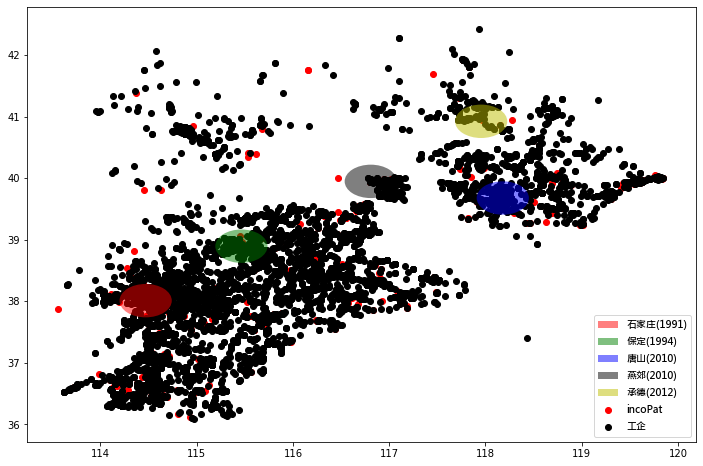

In [55]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(patented['lnt'], patented['lat'],c='r',label='incoPat')
ax.scatter(not_patented['lnt'], not_patented['lat'],c='k',label='工企')
cir1 = Circle(xy = (114.46931, 38.00811), radius=30/110.574,facecolor='r' ,alpha=0.5,label='石家庄(1991)')
cir2 = Circle(xy = (115.46438, 38.893), radius=30/110.574,facecolor='g' ,alpha=0.5,label='保定(1994)')
cir3 = Circle(xy = (118.1803, 39.67562), radius=30/110.574,facecolor='b' ,alpha=0.5,label='唐山(2010)')
cir4 = Circle(xy = (116.80854, 39.94622), radius=30/110.574,facecolor='k' ,alpha=0.5,label='燕郊(2010)')
cir5 = Circle(xy = (117.95548, 40.92203), radius=30/110.574,facecolor='y' ,alpha=0.5,label='承德(2012)')

ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
ax.add_patch(cir4)
ax.add_patch(cir5)

ax.legend(loc=4,prop=myfont)

In [56]:
merge_df_clean_2['石家庄'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-114.46931)**2)+((x['lat']-38.00811)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['保定'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-115.46438)**2)+((x['lat']-38.893)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['唐山'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-118.1803)**2)+((x['lat']-39.67562)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['燕郊'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-116.80854)**2)+((x['lat']-39.94622)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['承德'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-117.95548)**2)+((x['lat']-40.92203)**2))**0.5)<(30/110.574) else 0,axis=1)

In [57]:
patented = merge_df_clean_2[merge_df_clean_2['申请人']!='']
not_patented = merge_df_clean_2[merge_df_clean_2['申请人']=='']

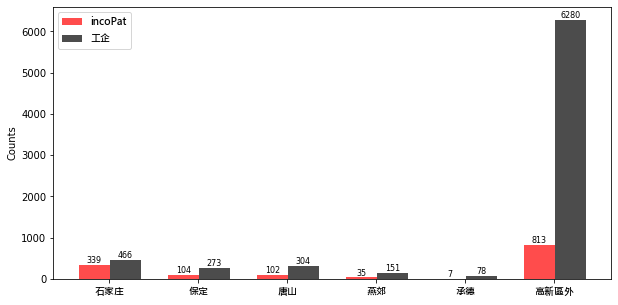

In [58]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Counts')
bar1 = ax1.bar(np.arange(0,6),[len(patented[patented['石家庄']==1]),len(patented[patented['保定']==1]),len(patented[patented['唐山']==1]),len(patented[patented['燕郊']==1]),len(patented[patented['承德']==1])
                                ,len(patented[(patented['石家庄']==0)&(patented['保定']==0)&(patented['唐山']==0)&(patented['燕郊']==0)&(patented['承德']==0)])]
               ,alpha=0.7,width=0.35,color='r',label='incoPat')
bar2 = ax1.bar(np.arange(0,6)+0.35,[len(not_patented[not_patented['石家庄']==1]),len(not_patented[not_patented['保定']==1]),len(not_patented[not_patented['唐山']==1]),len(not_patented[not_patented['燕郊']==1]),len(not_patented[not_patented['承德']==1])
                                ,len(not_patented[(not_patented['石家庄']==0)&(not_patented['保定']==0)&(not_patented['唐山']==0)&(not_patented['燕郊']==0)&(not_patented['承德']==0)])]
               ,alpha=0.7,width=0.35,color='k',label='工企')
for a,b in zip(np.arange(0,6),[len(patented[patented['石家庄']==1]),len(patented[patented['保定']==1]),len(patented[patented['唐山']==1]),len(patented[patented['燕郊']==1]),len(patented[patented['承德']==1])
                                ,len(patented[(patented['石家庄']==0)&(patented['保定']==0)&(patented['唐山']==0)&(patented['燕郊']==0)&(patented['承德']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=8)  
for a,b in zip(np.arange(0,6)+0.35,[len(not_patented[not_patented['石家庄']==1]),len(not_patented[not_patented['保定']==1]),len(not_patented[not_patented['唐山']==1]),len(not_patented[not_patented['燕郊']==1]),len(not_patented[not_patented['承德']==1])
                                ,len(not_patented[(not_patented['石家庄']==0)&(not_patented['保定']==0)&(not_patented['唐山']==0)&(not_patented['燕郊']==0)&(not_patented['承德']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=8) 

plt.xticks([0.17,1.17,2.17,3.17,4.17,5.17],['石家庄','保定','唐山','燕郊','承德','高新區外'],fontproperties=myfont)
plt.legend(handles = [bar1,bar2], loc='upper left',prop=myfont)

# 完整地址+非模糊比對

In [59]:
merge_df_clean_2 = merge_df_clean[merge_df_clean['lat']!='']
#完整地址
merge_df_clean_2 = merge_df_clean_2[merge_df_clean_2['完整地址']==1]
merge_df_clean_2 = merge_df_clean_2[((35<merge_df_clean_2['lat'])&(merge_df_clean_2['lat']<43))&((113<merge_df_clean_2['lnt'])&(merge_df_clean_2['lnt']<120))]
patented = merge_df_clean_2[merge_df_clean_2['申请人']!='']
not_patented = merge_df_clean_2[merge_df_clean_2['申请人']=='']

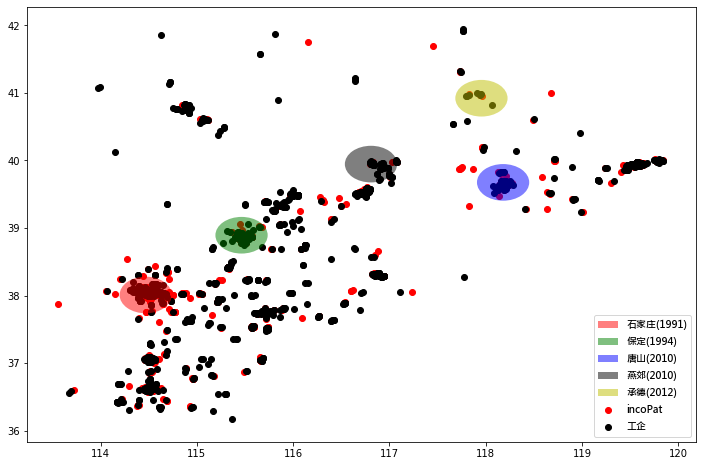

In [60]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(patented['lnt'], patented['lat'],c='r',label='incoPat')
ax.scatter(not_patented['lnt'], not_patented['lat'],c='k',label='工企')
cir1 = Circle(xy = (114.46931, 38.00811), radius=30/110.574,facecolor='r' ,alpha=0.5,label='石家庄(1991)')
cir2 = Circle(xy = (115.46438, 38.893), radius=30/110.574,facecolor='g' ,alpha=0.5,label='保定(1994)')
cir3 = Circle(xy = (118.1803, 39.67562), radius=30/110.574,facecolor='b' ,alpha=0.5,label='唐山(2010)')
cir4 = Circle(xy = (116.80854, 39.94622), radius=30/110.574,facecolor='k' ,alpha=0.5,label='燕郊(2010)')
cir5 = Circle(xy = (117.95548, 40.92203), radius=30/110.574,facecolor='y' ,alpha=0.5,label='承德(2012)')

ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
ax.add_patch(cir4)
ax.add_patch(cir5)

ax.legend(loc=4,prop=myfont)

In [61]:
merge_df_clean_2['石家庄'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-114.46931)**2)+((x['lat']-38.00811)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['保定'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-115.46438)**2)+((x['lat']-38.893)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['唐山'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-118.1803)**2)+((x['lat']-39.67562)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['燕郊'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-116.80854)**2)+((x['lat']-39.94622)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['承德'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-117.95548)**2)+((x['lat']-40.92203)**2))**0.5)<(30/110.574) else 0,axis=1)
patented = merge_df_clean_2[merge_df_clean_2['申请人']!='']
not_patented = merge_df_clean_2[merge_df_clean_2['申请人']=='']

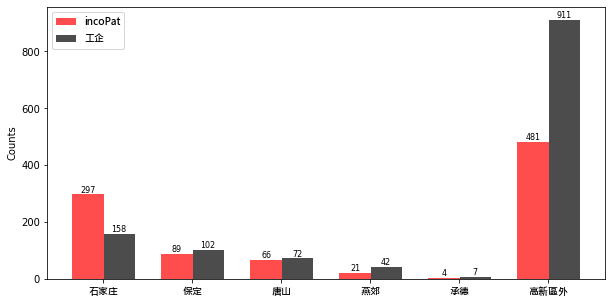

In [62]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Counts')
bar1 = ax1.bar(np.arange(0,6),[len(patented[patented['石家庄']==1]),len(patented[patented['保定']==1]),len(patented[patented['唐山']==1]),len(patented[patented['燕郊']==1]),len(patented[patented['承德']==1])
                                ,len(patented[(patented['石家庄']==0)&(patented['保定']==0)&(patented['唐山']==0)&(patented['燕郊']==0)&(patented['承德']==0)])]
               ,alpha=0.7,width=0.35,color='r',label='incoPat')
bar2 = ax1.bar(np.arange(0,6)+0.35,[len(not_patented[not_patented['石家庄']==1]),len(not_patented[not_patented['保定']==1]),len(not_patented[not_patented['唐山']==1]),len(not_patented[not_patented['燕郊']==1]),len(not_patented[not_patented['承德']==1])
                                ,len(not_patented[(not_patented['石家庄']==0)&(not_patented['保定']==0)&(not_patented['唐山']==0)&(not_patented['燕郊']==0)&(not_patented['承德']==0)])]
               ,alpha=0.7,width=0.35,color='k',label='工企')
for a,b in zip(np.arange(0,6),[len(patented[patented['石家庄']==1]),len(patented[patented['保定']==1]),len(patented[patented['唐山']==1]),len(patented[patented['燕郊']==1]),len(patented[patented['承德']==1])
                                ,len(patented[(patented['石家庄']==0)&(patented['保定']==0)&(patented['唐山']==0)&(patented['燕郊']==0)&(patented['承德']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=8)  
for a,b in zip(np.arange(0,6)+0.35,[len(not_patented[not_patented['石家庄']==1]),len(not_patented[not_patented['保定']==1]),len(not_patented[not_patented['唐山']==1]),len(not_patented[not_patented['燕郊']==1]),len(not_patented[not_patented['承德']==1])
                                ,len(not_patented[(not_patented['石家庄']==0)&(not_patented['保定']==0)&(not_patented['唐山']==0)&(not_patented['燕郊']==0)&(not_patented['承德']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=8) 

plt.xticks([0.17,1.17,2.17,3.17,4.17,5.17],['石家庄','保定','唐山','燕郊','承德','高新區外'],fontproperties=myfont)
plt.legend(handles = [bar1,bar2], loc='upper left',prop=myfont)

# 寬鬆地址+模糊比對

In [63]:
merge_df_clean_2 =merge_df_fuzzy_clean[merge_df_fuzzy_clean['lat']!='']
merge_df_clean_2 = merge_df_clean_2[((35<merge_df_clean_2['lat'])&(merge_df_clean_2['lat']<43))&((113<merge_df_clean_2['lnt'])&(merge_df_clean_2['lnt']<120))]
patented = merge_df_clean_2[merge_df_clean_2['申请人']!='']
not_patented = merge_df_clean_2[merge_df_clean_2['申请人']=='']

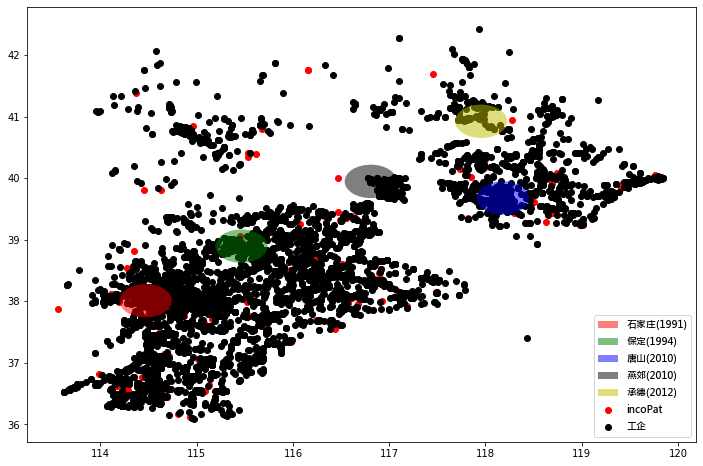

In [64]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(patented['lnt'], patented['lat'],c='r',label='incoPat')
ax.scatter(not_patented['lnt'], not_patented['lat'],c='k',label='工企')
cir1 = Circle(xy = (114.46931, 38.00811), radius=30/110.574,facecolor='r' ,alpha=0.5,label='石家庄(1991)')
cir2 = Circle(xy = (115.46438, 38.893), radius=30/110.574,facecolor='g' ,alpha=0.5,label='保定(1994)')
cir3 = Circle(xy = (118.1803, 39.67562), radius=30/110.574,facecolor='b' ,alpha=0.5,label='唐山(2010)')
cir4 = Circle(xy = (116.80854, 39.94622), radius=30/110.574,facecolor='k' ,alpha=0.5,label='燕郊(2010)')
cir5 = Circle(xy = (117.95548, 40.92203), radius=30/110.574,facecolor='y' ,alpha=0.5,label='承德(2012)')

ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
ax.add_patch(cir4)
ax.add_patch(cir5)

ax.legend(loc=4,prop=myfont)

In [65]:
merge_df_clean_2['石家庄'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-114.46931)**2)+((x['lat']-38.00811)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['保定'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-115.46438)**2)+((x['lat']-38.893)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['唐山'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-118.1803)**2)+((x['lat']-39.67562)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['燕郊'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-116.80854)**2)+((x['lat']-39.94622)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['承德'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-117.95548)**2)+((x['lat']-40.92203)**2))**0.5)<(30/110.574) else 0,axis=1)
patented = merge_df_clean_2[merge_df_clean_2['申请人']!='']
not_patented = merge_df_clean_2[merge_df_clean_2['申请人']=='']

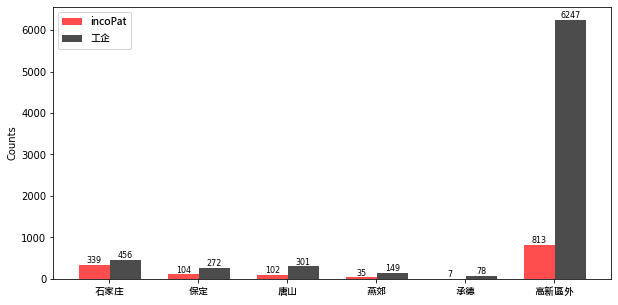

In [66]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Counts')
bar1 = ax1.bar(np.arange(0,6),[len(patented[patented['石家庄']==1]),len(patented[patented['保定']==1]),len(patented[patented['唐山']==1]),len(patented[patented['燕郊']==1]),len(patented[patented['承德']==1])
                                ,len(patented[(patented['石家庄']==0)&(patented['保定']==0)&(patented['唐山']==0)&(patented['燕郊']==0)&(patented['承德']==0)])]
               ,alpha=0.7,width=0.35,color='r',label='incoPat')
bar2 = ax1.bar(np.arange(0,6)+0.35,[len(not_patented[not_patented['石家庄']==1]),len(not_patented[not_patented['保定']==1]),len(not_patented[not_patented['唐山']==1]),len(not_patented[not_patented['燕郊']==1]),len(not_patented[not_patented['承德']==1])
                                ,len(not_patented[(not_patented['石家庄']==0)&(not_patented['保定']==0)&(not_patented['唐山']==0)&(not_patented['燕郊']==0)&(not_patented['承德']==0)])]
               ,alpha=0.7,width=0.35,color='k',label='工企')
for a,b in zip(np.arange(0,6),[len(patented[patented['石家庄']==1]),len(patented[patented['保定']==1]),len(patented[patented['唐山']==1]),len(patented[patented['燕郊']==1]),len(patented[patented['承德']==1])
                                ,len(patented[(patented['石家庄']==0)&(patented['保定']==0)&(patented['唐山']==0)&(patented['燕郊']==0)&(patented['承德']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=8)  
for a,b in zip(np.arange(0,6)+0.35,[len(not_patented[not_patented['石家庄']==1]),len(not_patented[not_patented['保定']==1]),len(not_patented[not_patented['唐山']==1]),len(not_patented[not_patented['燕郊']==1]),len(not_patented[not_patented['承德']==1])
                                ,len(not_patented[(not_patented['石家庄']==0)&(not_patented['保定']==0)&(not_patented['唐山']==0)&(not_patented['燕郊']==0)&(not_patented['承德']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=8) 

plt.xticks([0.17,1.17,2.17,3.17,4.17,5.17],['石家庄','保定','唐山','燕郊','承德','高新區外'],fontproperties=myfont)
plt.legend(handles = [bar1,bar2], loc='upper left',prop=myfont)

# 完整地址+模糊比對

In [73]:
merge_df_clean_2 =merge_df_fuzzy_clean[merge_df_fuzzy_clean['lat']!='']
#完整地址
merge_df_clean_2 = merge_df_clean_2[merge_df_clean_2['完整地址']==1]
merge_df_clean_2 = merge_df_clean_2[((35<merge_df_clean_2['lat'])&(merge_df_clean_2['lat']<43))&((113<merge_df_clean_2['lnt'])&(merge_df_clean_2['lnt']<120))]
patented = merge_df_clean_2[merge_df_clean_2['申请人']!='']
not_patented = merge_df_clean_2[merge_df_clean_2['申请人']=='']

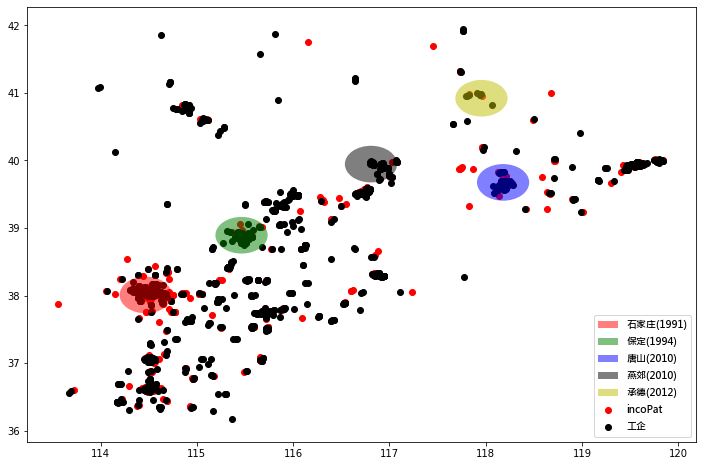

In [74]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(patented['lnt'], patented['lat'],c='r',label='incoPat')
ax.scatter(not_patented['lnt'], not_patented['lat'],c='k',label='工企')
cir1 = Circle(xy = (114.46931, 38.00811), radius=30/110.574,facecolor='r' ,alpha=0.5,label='石家庄(1991)')
cir2 = Circle(xy = (115.46438, 38.893), radius=30/110.574,facecolor='g' ,alpha=0.5,label='保定(1994)')
cir3 = Circle(xy = (118.1803, 39.67562), radius=30/110.574,facecolor='b' ,alpha=0.5,label='唐山(2010)')
cir4 = Circle(xy = (116.80854, 39.94622), radius=30/110.574,facecolor='k' ,alpha=0.5,label='燕郊(2010)')
cir5 = Circle(xy = (117.95548, 40.92203), radius=30/110.574,facecolor='y' ,alpha=0.5,label='承德(2012)')

ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
ax.add_patch(cir4)
ax.add_patch(cir5)

ax.legend(loc=4,prop=myfont)

In [75]:
merge_df_clean_2['石家庄'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-114.46931)**2)+((x['lat']-38.00811)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['保定'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-115.46438)**2)+((x['lat']-38.893)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['唐山'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-118.1803)**2)+((x['lat']-39.67562)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['燕郊'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-116.80854)**2)+((x['lat']-39.94622)**2))**0.5)<(30/110.574) else 0,axis=1)
merge_df_clean_2['承德'] = merge_df_clean_2.apply(lambda x:1 if ((((x['lnt']-117.95548)**2)+((x['lat']-40.92203)**2))**0.5)<(30/110.574) else 0,axis=1)
patented = merge_df_clean_2[merge_df_clean_2['申请人']!='']
not_patented = merge_df_clean_2[merge_df_clean_2['申请人']=='']

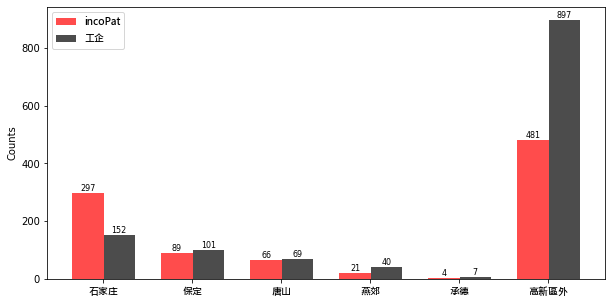

In [76]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Counts')
bar1 = ax1.bar(np.arange(0,6),[len(patented[patented['石家庄']==1]),len(patented[patented['保定']==1]),len(patented[patented['唐山']==1]),len(patented[patented['燕郊']==1]),len(patented[patented['承德']==1])
                                ,len(patented[(patented['石家庄']==0)&(patented['保定']==0)&(patented['唐山']==0)&(patented['燕郊']==0)&(patented['承德']==0)])]
               ,alpha=0.7,width=0.35,color='r',label='incoPat')
bar2 = ax1.bar(np.arange(0,6)+0.35,[len(not_patented[not_patented['石家庄']==1]),len(not_patented[not_patented['保定']==1]),len(not_patented[not_patented['唐山']==1]),len(not_patented[not_patented['燕郊']==1]),len(not_patented[not_patented['承德']==1])
                                ,len(not_patented[(not_patented['石家庄']==0)&(not_patented['保定']==0)&(not_patented['唐山']==0)&(not_patented['燕郊']==0)&(not_patented['承德']==0)])]
               ,alpha=0.7,width=0.35,color='k',label='工企')
for a,b in zip(np.arange(0,6),[len(patented[patented['石家庄']==1]),len(patented[patented['保定']==1]),len(patented[patented['唐山']==1]),len(patented[patented['燕郊']==1]),len(patented[patented['承德']==1])
                                ,len(patented[(patented['石家庄']==0)&(patented['保定']==0)&(patented['唐山']==0)&(patented['燕郊']==0)&(patented['承德']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=8)  
for a,b in zip(np.arange(0,6)+0.35,[len(not_patented[not_patented['石家庄']==1]),len(not_patented[not_patented['保定']==1]),len(not_patented[not_patented['唐山']==1]),len(not_patented[not_patented['燕郊']==1]),len(not_patented[not_patented['承德']==1])
                                ,len(not_patented[(not_patented['石家庄']==0)&(not_patented['保定']==0)&(not_patented['唐山']==0)&(not_patented['燕郊']==0)&(not_patented['承德']==0)])]):  
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=8) 

plt.xticks([0.17,1.17,2.17,3.17,4.17,5.17],['石家庄','保定','唐山','燕郊','承德','高新區外'],fontproperties=myfont)
plt.legend(handles = [bar1,bar2], loc='upper left',prop=myfont)